<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:14:29] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


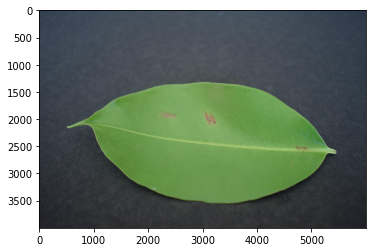

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

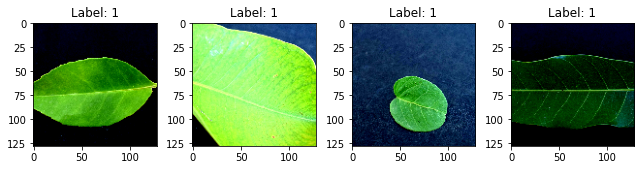

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:35] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:37] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2623046028117948 samples/sec                   batch loss = 0.6883537173271179 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2688980136635648 samples/sec                   batch loss = 0.749198853969574 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.2713992949459099 samples/sec                   batch loss = 0.8793507814407349 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2753870944225092 samples/sec                   batch loss = 0.5818616151809692 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.264665906585382 samples/sec                   batch loss = 0.7231221795082092 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.2637648181805035 samples/sec                   batch loss = 0.9124460220336914 | accuracy = 0.525


Epoch[1] Batch[35] Speed: 1.2677434955024665 samples/sec                   batch loss = 0.6372016072273254 | accuracy = 0.5214285714285715


Epoch[1] Batch[40] Speed: 1.2668880489223775 samples/sec                   batch loss = 0.8822614550590515 | accuracy = 0.51875


Epoch[1] Batch[45] Speed: 1.270803756173946 samples/sec                   batch loss = 0.8826022744178772 | accuracy = 0.5222222222222223


Epoch[1] Batch[50] Speed: 1.2659959245975079 samples/sec                   batch loss = 0.6585361957550049 | accuracy = 0.53


Epoch[1] Batch[55] Speed: 1.2778448457214722 samples/sec                   batch loss = 0.9898583889007568 | accuracy = 0.5318181818181819


Epoch[1] Batch[60] Speed: 1.2729753847804424 samples/sec                   batch loss = 0.873264491558075 | accuracy = 0.5458333333333333


Epoch[1] Batch[65] Speed: 1.270871429190413 samples/sec                   batch loss = 0.44132789969444275 | accuracy = 0.5653846153846154


Epoch[1] Batch[70] Speed: 1.27145556484086 samples/sec                   batch loss = 0.5843071341514587 | accuracy = 0.5714285714285714


Epoch[1] Batch[75] Speed: 1.2716843571042595 samples/sec                   batch loss = 0.3174903392791748 | accuracy = 0.5833333333333334


Epoch[1] Batch[80] Speed: 1.2761198060036871 samples/sec                   batch loss = 0.30135399103164673 | accuracy = 0.590625


Epoch[1] Batch[85] Speed: 1.2743590516800367 samples/sec                   batch loss = 0.5984415411949158 | accuracy = 0.5882352941176471


Epoch[1] Batch[90] Speed: 1.2736963342660899 samples/sec                   batch loss = 0.5930593609809875 | accuracy = 0.5916666666666667


Epoch[1] Batch[95] Speed: 1.2702446467111785 samples/sec                   batch loss = 0.8907036781311035 | accuracy = 0.5868421052631579


Epoch[1] Batch[100] Speed: 1.275311959774334 samples/sec                   batch loss = 0.7795814275741577 | accuracy = 0.59


Epoch[1] Batch[105] Speed: 1.2744065809791132 samples/sec                   batch loss = 1.125018835067749 | accuracy = 0.5928571428571429


Epoch[1] Batch[110] Speed: 1.275187885802645 samples/sec                   batch loss = 0.4199780523777008 | accuracy = 0.5931818181818181


Epoch[1] Batch[115] Speed: 1.2744653440970346 samples/sec                   batch loss = 0.6094158291816711 | accuracy = 0.5934782608695652


Epoch[1] Batch[120] Speed: 1.2711906387868557 samples/sec                   batch loss = 0.31065481901168823 | accuracy = 0.6020833333333333


Epoch[1] Batch[125] Speed: 1.2759807269079704 samples/sec                   batch loss = 0.45335155725479126 | accuracy = 0.602


Epoch[1] Batch[130] Speed: 1.271682814842046 samples/sec                   batch loss = 0.47954878211021423 | accuracy = 0.6038461538461538


Epoch[1] Batch[135] Speed: 1.27424997034105 samples/sec                   batch loss = 0.378904789686203 | accuracy = 0.6074074074074074


Epoch[1] Batch[140] Speed: 1.27342912050574 samples/sec                   batch loss = 0.5065980553627014 | accuracy = 0.6053571428571428


Epoch[1] Batch[145] Speed: 1.2679965406216587 samples/sec                   batch loss = 0.29788172245025635 | accuracy = 0.6120689655172413


Epoch[1] Batch[150] Speed: 1.2749630632521574 samples/sec                   batch loss = 0.4360719323158264 | accuracy = 0.6133333333333333


Epoch[1] Batch[155] Speed: 1.2756175948869508 samples/sec                   batch loss = 0.4303572475910187 | accuracy = 0.6161290322580645


Epoch[1] Batch[160] Speed: 1.2728958018043979 samples/sec                   batch loss = 0.9676734805107117 | accuracy = 0.6203125


Epoch[1] Batch[165] Speed: 1.2785741486868778 samples/sec                   batch loss = 0.29489099979400635 | accuracy = 0.6196969696969697


Epoch[1] Batch[170] Speed: 1.2739361873783608 samples/sec                   batch loss = 0.3177281320095062 | accuracy = 0.6235294117647059


Epoch[1] Batch[175] Speed: 1.27120865026005 samples/sec                   batch loss = 0.34170055389404297 | accuracy = 0.6257142857142857


Epoch[1] Batch[180] Speed: 1.2679059846628957 samples/sec                   batch loss = 0.8778836131095886 | accuracy = 0.6222222222222222


Epoch[1] Batch[185] Speed: 1.2659758633871394 samples/sec                   batch loss = 1.3696354627609253 | accuracy = 0.6229729729729729


Epoch[1] Batch[190] Speed: 1.2692442703554594 samples/sec                   batch loss = 0.40187644958496094 | accuracy = 0.6276315789473684


Epoch[1] Batch[195] Speed: 1.272232096674745 samples/sec                   batch loss = 0.44472774863243103 | accuracy = 0.6243589743589744


Epoch[1] Batch[200] Speed: 1.270390558477762 samples/sec                   batch loss = 0.44941964745521545 | accuracy = 0.62625


Epoch[1] Batch[205] Speed: 1.273054108314362 samples/sec                   batch loss = 0.2979125380516052 | accuracy = 0.6292682926829268


Epoch[1] Batch[210] Speed: 1.2762921197792758 samples/sec                   batch loss = 0.7289792895317078 | accuracy = 0.6309523809523809


Epoch[1] Batch[215] Speed: 1.2730417437283186 samples/sec                   batch loss = 0.528969407081604 | accuracy = 0.6325581395348837


Epoch[1] Batch[220] Speed: 1.2717981092546702 samples/sec                   batch loss = 0.7193946242332458 | accuracy = 0.634090909090909


Epoch[1] Batch[225] Speed: 1.2766438813613838 samples/sec                   batch loss = 0.6128408312797546 | accuracy = 0.6333333333333333


Epoch[1] Batch[230] Speed: 1.2707665053984727 samples/sec                   batch loss = 0.7388550639152527 | accuracy = 0.633695652173913


Epoch[1] Batch[235] Speed: 1.2714498798136493 samples/sec                   batch loss = 0.5075523257255554 | accuracy = 0.6351063829787233


Epoch[1] Batch[240] Speed: 1.267212726075068 samples/sec                   batch loss = 0.42782706022262573 | accuracy = 0.6364583333333333


Epoch[1] Batch[245] Speed: 1.2750099593433841 samples/sec                   batch loss = 0.7559163570404053 | accuracy = 0.6387755102040816


Epoch[1] Batch[250] Speed: 1.2750701347945417 samples/sec                   batch loss = 0.8482670783996582 | accuracy = 0.643


Epoch[1] Batch[255] Speed: 1.2749306062009145 samples/sec                   batch loss = 0.5660783648490906 | accuracy = 0.6441176470588236


Epoch[1] Batch[260] Speed: 1.2800234379291613 samples/sec                   batch loss = 0.5849915146827698 | accuracy = 0.6471153846153846


Epoch[1] Batch[265] Speed: 1.2728102418900074 samples/sec                   batch loss = 1.058838129043579 | accuracy = 0.6471698113207547


Epoch[1] Batch[270] Speed: 1.2766175556585 samples/sec                   batch loss = 0.7857486009597778 | accuracy = 0.6462962962962963


Epoch[1] Batch[275] Speed: 1.278441255972923 samples/sec                   batch loss = 0.3237987756729126 | accuracy = 0.6427272727272727


Epoch[1] Batch[280] Speed: 1.271673754127088 samples/sec                   batch loss = 0.8173162937164307 | accuracy = 0.6428571428571429


Epoch[1] Batch[285] Speed: 1.2688209547805809 samples/sec                   batch loss = 0.6024220585823059 | accuracy = 0.6385964912280702


Epoch[1] Batch[290] Speed: 1.2628575983613548 samples/sec                   batch loss = 0.2786373496055603 | accuracy = 0.6413793103448275


Epoch[1] Batch[295] Speed: 1.2763789252977602 samples/sec                   batch loss = 0.5624123215675354 | accuracy = 0.6423728813559322


Epoch[1] Batch[300] Speed: 1.2769709545937138 samples/sec                   batch loss = 0.6366240978240967 | accuracy = 0.6433333333333333


Epoch[1] Batch[305] Speed: 1.2677587270920188 samples/sec                   batch loss = 0.6698411703109741 | accuracy = 0.639344262295082


Epoch[1] Batch[310] Speed: 1.2728681818840497 samples/sec                   batch loss = 0.5146231651306152 | accuracy = 0.6427419354838709


Epoch[1] Batch[315] Speed: 1.2770061400088248 samples/sec                   batch loss = 0.621249258518219 | accuracy = 0.6436507936507937


Epoch[1] Batch[320] Speed: 1.2766027904258685 samples/sec                   batch loss = 0.6308181285858154 | accuracy = 0.6453125


Epoch[1] Batch[325] Speed: 1.276815753680701 samples/sec                   batch loss = 0.9416963458061218 | accuracy = 0.6476923076923077


Epoch[1] Batch[330] Speed: 1.2688157730744984 samples/sec                   batch loss = 0.6867591738700867 | accuracy = 0.6477272727272727


Epoch[1] Batch[335] Speed: 1.2677642833604472 samples/sec                   batch loss = 0.5923879146575928 | accuracy = 0.6477611940298508


Epoch[1] Batch[340] Speed: 1.272858235143363 samples/sec                   batch loss = 1.8776684999465942 | accuracy = 0.6470588235294118


Epoch[1] Batch[345] Speed: 1.2655480423067935 samples/sec                   batch loss = 0.7099887728691101 | accuracy = 0.6478260869565218


Epoch[1] Batch[350] Speed: 1.2674628782527566 samples/sec                   batch loss = 0.3277329206466675 | accuracy = 0.6485714285714286


Epoch[1] Batch[355] Speed: 1.2693873591922753 samples/sec                   batch loss = 0.3593291938304901 | accuracy = 0.65


Epoch[1] Batch[360] Speed: 1.2680230869891789 samples/sec                   batch loss = 0.5574272871017456 | accuracy = 0.6493055555555556


Epoch[1] Batch[365] Speed: 1.268227636710866 samples/sec                   batch loss = 0.5473437309265137 | accuracy = 0.6486301369863013


Epoch[1] Batch[370] Speed: 1.265029506167552 samples/sec                   batch loss = 0.6603009104728699 | accuracy = 0.65


Epoch[1] Batch[375] Speed: 1.2676776877469804 samples/sec                   batch loss = 0.24630293250083923 | accuracy = 0.6526666666666666


Epoch[1] Batch[380] Speed: 1.273152647193052 samples/sec                   batch loss = 0.3337733745574951 | accuracy = 0.6532894736842105


Epoch[1] Batch[385] Speed: 1.2742426150399857 samples/sec                   batch loss = 0.39873430132865906 | accuracy = 0.6551948051948052


Epoch[1] Batch[390] Speed: 1.2662546756551956 samples/sec                   batch loss = 0.6603214740753174 | accuracy = 0.6557692307692308


Epoch[1] Batch[395] Speed: 1.2637564411052036 samples/sec                   batch loss = 0.509419322013855 | accuracy = 0.6575949367088607


Epoch[1] Batch[400] Speed: 1.2669843916812524 samples/sec                   batch loss = 0.14756730198860168 | accuracy = 0.658125


Epoch[1] Batch[405] Speed: 1.274973527370199 samples/sec                   batch loss = 0.6745491027832031 | accuracy = 0.6580246913580247


Epoch[1] Batch[410] Speed: 1.2691594886359983 samples/sec                   batch loss = 0.9656944274902344 | accuracy = 0.6591463414634147


Epoch[1] Batch[415] Speed: 1.2701954078526243 samples/sec                   batch loss = 0.5726817846298218 | accuracy = 0.6590361445783133


Epoch[1] Batch[420] Speed: 1.2736715803777996 samples/sec                   batch loss = 0.4120674431324005 | accuracy = 0.6577380952380952


Epoch[1] Batch[425] Speed: 1.273308021820744 samples/sec                   batch loss = 0.562435507774353 | accuracy = 0.6576470588235294


Epoch[1] Batch[430] Speed: 1.2720000212287907 samples/sec                   batch loss = 0.44617170095443726 | accuracy = 0.6593023255813953


Epoch[1] Batch[435] Speed: 1.2705129309016314 samples/sec                   batch loss = 0.37199684977531433 | accuracy = 0.6609195402298851


Epoch[1] Batch[440] Speed: 1.2680794418073387 samples/sec                   batch loss = 0.5760035514831543 | accuracy = 0.6625


Epoch[1] Batch[445] Speed: 1.275065192635193 samples/sec                   batch loss = 0.26751816272735596 | accuracy = 0.6617977528089888


Epoch[1] Batch[450] Speed: 1.2690726063270514 samples/sec                   batch loss = 0.5441666841506958 | accuracy = 0.6633333333333333


Epoch[1] Batch[455] Speed: 1.2735139902937274 samples/sec                   batch loss = 0.4763803780078888 | accuracy = 0.6631868131868132


Epoch[1] Batch[460] Speed: 1.269096125777857 samples/sec                   batch loss = 1.204577088356018 | accuracy = 0.6635869565217392


Epoch[1] Batch[465] Speed: 1.2627556093189667 samples/sec                   batch loss = 0.527558445930481 | accuracy = 0.6645161290322581


Epoch[1] Batch[470] Speed: 1.2737980673777887 samples/sec                   batch loss = 0.6823909282684326 | accuracy = 0.6654255319148936


Epoch[1] Batch[475] Speed: 1.2707080828702773 samples/sec                   batch loss = 0.431654155254364 | accuracy = 0.6652631578947369


Epoch[1] Batch[480] Speed: 1.2727393691369266 samples/sec                   batch loss = 0.3484799563884735 | accuracy = 0.6661458333333333


Epoch[1] Batch[485] Speed: 1.2694970504644496 samples/sec                   batch loss = 0.8616841435432434 | accuracy = 0.6675257731958762


Epoch[1] Batch[490] Speed: 1.2675042447284455 samples/sec                   batch loss = 0.5863825678825378 | accuracy = 0.6693877551020408


Epoch[1] Batch[495] Speed: 1.2585750716074011 samples/sec                   batch loss = 0.9358790516853333 | accuracy = 0.6702020202020202


Epoch[1] Batch[500] Speed: 1.2689579015002737 samples/sec                   batch loss = 0.45634543895721436 | accuracy = 0.672


Epoch[1] Batch[505] Speed: 1.2727572314165574 samples/sec                   batch loss = 0.37434354424476624 | accuracy = 0.6722772277227723


Epoch[1] Batch[510] Speed: 1.2669063213484597 samples/sec                   batch loss = 0.49282214045524597 | accuracy = 0.6730392156862746


Epoch[1] Batch[515] Speed: 1.2679243822868627 samples/sec                   batch loss = 0.7609122395515442 | accuracy = 0.6737864077669903


Epoch[1] Batch[520] Speed: 1.26524358698613 samples/sec                   batch loss = 0.335960328578949 | accuracy = 0.675


Epoch[1] Batch[525] Speed: 1.2679046431903658 samples/sec                   batch loss = 0.3595254123210907 | accuracy = 0.6747619047619048


Epoch[1] Batch[530] Speed: 1.269893806999063 samples/sec                   batch loss = 0.9774032235145569 | accuracy = 0.6759433962264151


Epoch[1] Batch[535] Speed: 1.2679225616648546 samples/sec                   batch loss = 0.3266422152519226 | accuracy = 0.6766355140186916


Epoch[1] Batch[540] Speed: 1.264518161622138 samples/sec                   batch loss = 0.4266449511051178 | accuracy = 0.6763888888888889


Epoch[1] Batch[545] Speed: 1.2674005463720077 samples/sec                   batch loss = 0.36078956723213196 | accuracy = 0.6770642201834862


Epoch[1] Batch[550] Speed: 1.2648501118763877 samples/sec                   batch loss = 0.39147666096687317 | accuracy = 0.6763636363636364


Epoch[1] Batch[555] Speed: 1.2698043253472748 samples/sec                   batch loss = 0.3823118805885315 | accuracy = 0.677027027027027


Epoch[1] Batch[560] Speed: 1.2654487680494027 samples/sec                   batch loss = 1.1840511560440063 | accuracy = 0.6754464285714286


Epoch[1] Batch[565] Speed: 1.269197989462547 samples/sec                   batch loss = 0.42105552554130554 | accuracy = 0.6778761061946903


Epoch[1] Batch[570] Speed: 1.2635594214739223 samples/sec                   batch loss = 0.33822545409202576 | accuracy = 0.6793859649122806


Epoch[1] Batch[575] Speed: 1.2639758047844376 samples/sec                   batch loss = 0.505952000617981 | accuracy = 0.6804347826086956


Epoch[1] Batch[580] Speed: 1.264081229264554 samples/sec                   batch loss = 0.39128467440605164 | accuracy = 0.6810344827586207


Epoch[1] Batch[585] Speed: 1.2649514858106645 samples/sec                   batch loss = 0.4659312963485718 | accuracy = 0.6807692307692308


Epoch[1] Batch[590] Speed: 1.2683987845241464 samples/sec                   batch loss = 0.602213442325592 | accuracy = 0.6805084745762712


Epoch[1] Batch[595] Speed: 1.2641885764999434 samples/sec                   batch loss = 0.5113207101821899 | accuracy = 0.680672268907563


Epoch[1] Batch[600] Speed: 1.2745105576308828 samples/sec                   batch loss = 0.32186272740364075 | accuracy = 0.6808333333333333


Epoch[1] Batch[605] Speed: 1.2662242850796668 samples/sec                   batch loss = 0.7309606671333313 | accuracy = 0.6809917355371901


Epoch[1] Batch[610] Speed: 1.2697357088647103 samples/sec                   batch loss = 0.5230115652084351 | accuracy = 0.6819672131147541


Epoch[1] Batch[615] Speed: 1.263682575339428 samples/sec                   batch loss = 0.5262458920478821 | accuracy = 0.6833333333333333


Epoch[1] Batch[620] Speed: 1.2654194660295779 samples/sec                   batch loss = 0.6796385049819946 | accuracy = 0.6826612903225806


Epoch[1] Batch[625] Speed: 1.267697707141647 samples/sec                   batch loss = 0.6448033452033997 | accuracy = 0.6812


Epoch[1] Batch[630] Speed: 1.2626252242133735 samples/sec                   batch loss = 0.4992198348045349 | accuracy = 0.6805555555555556


Epoch[1] Batch[635] Speed: 1.2635478116058427 samples/sec                   batch loss = 0.2353217601776123 | accuracy = 0.6826771653543308


Epoch[1] Batch[640] Speed: 1.2730038786776228 samples/sec                   batch loss = 0.23860807716846466 | accuracy = 0.683984375


Epoch[1] Batch[645] Speed: 1.2776257013828825 samples/sec                   batch loss = 0.23946401476860046 | accuracy = 0.6844961240310078


Epoch[1] Batch[650] Speed: 1.273297391751003 samples/sec                   batch loss = 0.9184395670890808 | accuracy = 0.685


Epoch[1] Batch[655] Speed: 1.2721174952232706 samples/sec                   batch loss = 0.24567241966724396 | accuracy = 0.6866412213740458


Epoch[1] Batch[660] Speed: 1.2688896643661012 samples/sec                   batch loss = 0.3131569027900696 | accuracy = 0.6871212121212121


Epoch[1] Batch[665] Speed: 1.2619318418153411 samples/sec                   batch loss = 0.4252561032772064 | accuracy = 0.687593984962406


Epoch[1] Batch[670] Speed: 1.2674792521598506 samples/sec                   batch loss = 0.08439255505800247 | accuracy = 0.6880597014925374


Epoch[1] Batch[675] Speed: 1.2687150260901077 samples/sec                   batch loss = 0.26724252104759216 | accuracy = 0.6881481481481482


Epoch[1] Batch[680] Speed: 1.2661410529536283 samples/sec                   batch loss = 0.17845654487609863 | accuracy = 0.6889705882352941


Epoch[1] Batch[685] Speed: 1.2634588414208243 samples/sec                   batch loss = 1.0371288061141968 | accuracy = 0.6894160583941605


Epoch[1] Batch[690] Speed: 1.268031712401987 samples/sec                   batch loss = 0.33938658237457275 | accuracy = 0.6902173913043478


Epoch[1] Batch[695] Speed: 1.2730092878326706 samples/sec                   batch loss = 0.41773533821105957 | accuracy = 0.689568345323741


Epoch[1] Batch[700] Speed: 1.2665654504387627 samples/sec                   batch loss = 0.5287664532661438 | accuracy = 0.6903571428571429


Epoch[1] Batch[705] Speed: 1.263060770079976 samples/sec                   batch loss = 0.21110032498836517 | accuracy = 0.6921985815602837


Epoch[1] Batch[710] Speed: 1.2653869204256327 samples/sec                   batch loss = 0.6348774433135986 | accuracy = 0.6922535211267605


Epoch[1] Batch[715] Speed: 1.2703746864235896 samples/sec                   batch loss = 0.19392357766628265 | accuracy = 0.6926573426573427


Epoch[1] Batch[720] Speed: 1.2679587834433332 samples/sec                   batch loss = 0.32598382234573364 | accuracy = 0.6930555555555555


Epoch[1] Batch[725] Speed: 1.2730053275539317 samples/sec                   batch loss = 0.7726930975914001 | accuracy = 0.6931034482758621


Epoch[1] Batch[730] Speed: 1.2740480207477989 samples/sec                   batch loss = 0.32792624831199646 | accuracy = 0.6938356164383561


Epoch[1] Batch[735] Speed: 1.2689795930407535 samples/sec                   batch loss = 0.2606136202812195 | accuracy = 0.6945578231292517


Epoch[1] Batch[740] Speed: 1.271251417513841 samples/sec                   batch loss = 0.5769684910774231 | accuracy = 0.6949324324324324


Epoch[1] Batch[745] Speed: 1.2699659012830524 samples/sec                   batch loss = 0.5681119561195374 | accuracy = 0.6959731543624161


Epoch[1] Batch[750] Speed: 1.271584214217003 samples/sec                   batch loss = 0.5235227346420288 | accuracy = 0.696


Epoch[1] Batch[755] Speed: 1.2689937025381515 samples/sec                   batch loss = 0.3661002814769745 | accuracy = 0.6970198675496688


Epoch[1] Batch[760] Speed: 1.2706893156528245 samples/sec                   batch loss = 0.38003188371658325 | accuracy = 0.6973684210526315


Epoch[1] Batch[765] Speed: 1.2739071680862306 samples/sec                   batch loss = 0.6932292580604553 | accuracy = 0.6970588235294117


Epoch[1] Batch[770] Speed: 1.2697491624925 samples/sec                   batch loss = 0.920392632484436 | accuracy = 0.6967532467532468


Epoch[1] Batch[775] Speed: 1.268208271632095 samples/sec                   batch loss = 0.8127213716506958 | accuracy = 0.6967741935483871


Epoch[1] Batch[780] Speed: 1.2659132956006438 samples/sec                   batch loss = 0.5243566632270813 | accuracy = 0.698076923076923


Epoch[1] Batch[785] Speed: 1.2686541059151095 samples/sec                   batch loss = 0.6332949995994568 | accuracy = 0.6980891719745222


[Epoch 1] training: accuracy=0.6976522842639594
[Epoch 1] time cost: 647.4417769908905
[Epoch 1] validation: validation accuracy=0.7066666666666667


Epoch[2] Batch[5] Speed: 1.2710293288306074 samples/sec                   batch loss = 0.32823556661605835 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2730011741173368 samples/sec                   batch loss = 0.5515807867050171 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2721862729099773 samples/sec                   batch loss = 0.5476341843605042 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2691585285454867 samples/sec                   batch loss = 0.2750931680202484 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2589444347936036 samples/sec                   batch loss = 0.9265576004981995 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.2674319509158036 samples/sec                   batch loss = 0.2795189321041107 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2669600893453252 samples/sec                   batch loss = 0.3360414505004883 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.2636846693530321 samples/sec                   batch loss = 0.7289180755615234 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.2711661748225356 samples/sec                   batch loss = 0.39369916915893555 | accuracy = 0.7333333333333333


Epoch[2] Batch[50] Speed: 1.2625648874516573 samples/sec                   batch loss = 0.3055358827114105 | accuracy = 0.735


Epoch[2] Batch[55] Speed: 1.26802902892765 samples/sec                   batch loss = 0.7551196813583374 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2695544009958954 samples/sec                   batch loss = 0.4342232048511505 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.26757855795737 samples/sec                   batch loss = 0.30685412883758545 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2688682637950495 samples/sec                   batch loss = 0.36194124817848206 | accuracy = 0.7392857142857143


Epoch[2] Batch[75] Speed: 1.2667277333770646 samples/sec                   batch loss = 0.36678412556648254 | accuracy = 0.7366666666666667


Epoch[2] Batch[80] Speed: 1.2665303599505866 samples/sec                   batch loss = 0.3842043876647949 | accuracy = 0.740625


Epoch[2] Batch[85] Speed: 1.2646899303197008 samples/sec                   batch loss = 0.3520088791847229 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.266911391800953 samples/sec                   batch loss = 0.8181138634681702 | accuracy = 0.7444444444444445


Epoch[2] Batch[95] Speed: 1.2700732888789432 samples/sec                   batch loss = 0.6733987927436829 | accuracy = 0.7421052631578947


Epoch[2] Batch[100] Speed: 1.2708235856427643 samples/sec                   batch loss = 0.5971991419792175 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.2670860123344632 samples/sec                   batch loss = 0.49814870953559875 | accuracy = 0.7404761904761905


Epoch[2] Batch[110] Speed: 1.2741972269687658 samples/sec                   batch loss = 0.7856688499450684 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.2754740677725143 samples/sec                   batch loss = 0.3986961841583252 | accuracy = 0.7326086956521739


Epoch[2] Batch[120] Speed: 1.2755356447066561 samples/sec                   batch loss = 0.7113654613494873 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.2798037410339753 samples/sec                   batch loss = 0.44681060314178467 | accuracy = 0.736


Epoch[2] Batch[130] Speed: 1.2732548732468592 samples/sec                   batch loss = 0.2907065153121948 | accuracy = 0.7365384615384616


Epoch[2] Batch[135] Speed: 1.267313330329952 samples/sec                   batch loss = 0.23380616307258606 | accuracy = 0.7388888888888889


Epoch[2] Batch[140] Speed: 1.2680141741858857 samples/sec                   batch loss = 0.5351592302322388 | accuracy = 0.7375


Epoch[2] Batch[145] Speed: 1.2711411339445167 samples/sec                   batch loss = 0.30749621987342834 | accuracy = 0.743103448275862


Epoch[2] Batch[150] Speed: 1.265475398749355 samples/sec                   batch loss = 0.4260919392108917 | accuracy = 0.74


Epoch[2] Batch[155] Speed: 1.2725394423744338 samples/sec                   batch loss = 0.3841254711151123 | accuracy = 0.7451612903225806


Epoch[2] Batch[160] Speed: 1.2703894041331762 samples/sec                   batch loss = 0.33539479970932007 | accuracy = 0.75


Epoch[2] Batch[165] Speed: 1.2590561080620504 samples/sec                   batch loss = 0.24423500895500183 | accuracy = 0.7545454545454545


Epoch[2] Batch[170] Speed: 1.2672662329147488 samples/sec                   batch loss = 0.5863696336746216 | accuracy = 0.7588235294117647


Epoch[2] Batch[175] Speed: 1.2648539262175278 samples/sec                   batch loss = 0.711174726486206 | accuracy = 0.7542857142857143


Epoch[2] Batch[180] Speed: 1.2639454282747513 samples/sec                   batch loss = 0.27464714646339417 | accuracy = 0.75


Epoch[2] Batch[185] Speed: 1.2666218670160043 samples/sec                   batch loss = 0.3429061472415924 | accuracy = 0.7513513513513513


Epoch[2] Batch[190] Speed: 1.2698539183461972 samples/sec                   batch loss = 0.44333967566490173 | accuracy = 0.7513157894736842


Epoch[2] Batch[195] Speed: 1.2697285977766224 samples/sec                   batch loss = 0.217911958694458 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.2749556997164995 samples/sec                   batch loss = 0.6092166900634766 | accuracy = 0.75


Epoch[2] Batch[205] Speed: 1.27124929834792 samples/sec                   batch loss = 0.4156166613101959 | accuracy = 0.748780487804878


Epoch[2] Batch[210] Speed: 1.2727861017825832 samples/sec                   batch loss = 0.34623271226882935 | accuracy = 0.7523809523809524


Epoch[2] Batch[215] Speed: 1.2765614107385608 samples/sec                   batch loss = 0.340631365776062 | accuracy = 0.7511627906976744


Epoch[2] Batch[220] Speed: 1.272535388497921 samples/sec                   batch loss = 0.6828424334526062 | accuracy = 0.75


Epoch[2] Batch[225] Speed: 1.2667295505693565 samples/sec                   batch loss = 0.2204778790473938 | accuracy = 0.7511111111111111


Epoch[2] Batch[230] Speed: 1.2689400497268035 samples/sec                   batch loss = 1.1125428676605225 | accuracy = 0.7510869565217392


Epoch[2] Batch[235] Speed: 1.2682966655649754 samples/sec                   batch loss = 0.5930041670799255 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2682261028216741 samples/sec                   batch loss = 0.3862459659576416 | accuracy = 0.7489583333333333


Epoch[2] Batch[245] Speed: 1.2665477615300262 samples/sec                   batch loss = 0.5276636481285095 | accuracy = 0.746938775510204


Epoch[2] Batch[250] Speed: 1.2681413612090553 samples/sec                   batch loss = 1.1185071468353271 | accuracy = 0.75


Epoch[2] Batch[255] Speed: 1.2641771455809676 samples/sec                   batch loss = 0.08564551919698715 | accuracy = 0.7509803921568627


Epoch[2] Batch[260] Speed: 1.2692875777331225 samples/sec                   batch loss = 0.7702763676643372 | accuracy = 0.7509615384615385


Epoch[2] Batch[265] Speed: 1.2758948488186357 samples/sec                   batch loss = 0.4351019263267517 | accuracy = 0.7537735849056604


Epoch[2] Batch[270] Speed: 1.2783897236375994 samples/sec                   batch loss = 0.40130096673965454 | accuracy = 0.7564814814814815


Epoch[2] Batch[275] Speed: 1.275545924270026 samples/sec                   batch loss = 0.2460009753704071 | accuracy = 0.7572727272727273


Epoch[2] Batch[280] Speed: 1.2758376031809064 samples/sec                   batch loss = 0.4272648096084595 | accuracy = 0.7598214285714285


Epoch[2] Batch[285] Speed: 1.2720245172991818 samples/sec                   batch loss = 0.8162397742271423 | accuracy = 0.7570175438596491


Epoch[2] Batch[290] Speed: 1.2652302286660964 samples/sec                   batch loss = 0.40648141503334045 | accuracy = 0.7560344827586207


Epoch[2] Batch[295] Speed: 1.27461232402132 samples/sec                   batch loss = 0.26282998919487 | accuracy = 0.7576271186440678


Epoch[2] Batch[300] Speed: 1.2732317791585637 samples/sec                   batch loss = 0.4648457169532776 | accuracy = 0.7608333333333334


Epoch[2] Batch[305] Speed: 1.2734527050521272 samples/sec                   batch loss = 0.6007851958274841 | accuracy = 0.7581967213114754


Epoch[2] Batch[310] Speed: 1.2689513749872081 samples/sec                   batch loss = 0.5015424489974976 | accuracy = 0.7580645161290323


Epoch[2] Batch[315] Speed: 1.2667921034194036 samples/sec                   batch loss = 0.18184486031532288 | accuracy = 0.7555555555555555


Epoch[2] Batch[320] Speed: 1.2760835046976489 samples/sec                   batch loss = 0.16188013553619385 | accuracy = 0.75625


Epoch[2] Batch[325] Speed: 1.2686817351277395 samples/sec                   batch loss = 0.9439395070075989 | accuracy = 0.7553846153846154


Epoch[2] Batch[330] Speed: 1.2772007639811032 samples/sec                   batch loss = 0.5025956034660339 | accuracy = 0.7560606060606061


Epoch[2] Batch[335] Speed: 1.274670912425302 samples/sec                   batch loss = 0.46657824516296387 | accuracy = 0.7574626865671642


Epoch[2] Batch[340] Speed: 1.275069359551326 samples/sec                   batch loss = 0.7245328426361084 | accuracy = 0.7580882352941176


Epoch[2] Batch[345] Speed: 1.2748040879219775 samples/sec                   batch loss = 0.5145711898803711 | accuracy = 0.7594202898550725


Epoch[2] Batch[350] Speed: 1.2766228984255137 samples/sec                   batch loss = 0.41694948077201843 | accuracy = 0.7585714285714286


Epoch[2] Batch[355] Speed: 1.275082732628922 samples/sec                   batch loss = 0.8280090093612671 | accuracy = 0.7577464788732394


Epoch[2] Batch[360] Speed: 1.2689777693871167 samples/sec                   batch loss = 0.5425497889518738 | accuracy = 0.7576388888888889


Epoch[2] Batch[365] Speed: 1.2663778775532448 samples/sec                   batch loss = 0.5339353084564209 | accuracy = 0.7595890410958904


Epoch[2] Batch[370] Speed: 1.2756526087661 samples/sec                   batch loss = 0.7447524070739746 | accuracy = 0.7587837837837837


Epoch[2] Batch[375] Speed: 1.2716064775377554 samples/sec                   batch loss = 0.9238356947898865 | accuracy = 0.756


Epoch[2] Batch[380] Speed: 1.2679606999971962 samples/sec                   batch loss = 0.7559112310409546 | accuracy = 0.7552631578947369


Epoch[2] Batch[385] Speed: 1.282957206965396 samples/sec                   batch loss = 0.17792627215385437 | accuracy = 0.7558441558441559


Epoch[2] Batch[390] Speed: 1.2748942756411017 samples/sec                   batch loss = 0.14068199694156647 | accuracy = 0.7557692307692307


Epoch[2] Batch[395] Speed: 1.2699239894765024 samples/sec                   batch loss = 0.38602226972579956 | accuracy = 0.7563291139240507


Epoch[2] Batch[400] Speed: 1.274840122730182 samples/sec                   batch loss = 0.5446715950965881 | accuracy = 0.755625


Epoch[2] Batch[405] Speed: 1.2748525222750577 samples/sec                   batch loss = 0.8155237436294556 | accuracy = 0.754320987654321


Epoch[2] Batch[410] Speed: 1.273526460725988 samples/sec                   batch loss = 0.37033969163894653 | accuracy = 0.7548780487804878


Epoch[2] Batch[415] Speed: 1.272336780183805 samples/sec                   batch loss = 0.16433928906917572 | accuracy = 0.7560240963855421


Epoch[2] Batch[420] Speed: 1.2767921415699737 samples/sec                   batch loss = 0.34511882066726685 | accuracy = 0.756547619047619


Epoch[2] Batch[425] Speed: 1.275218902032191 samples/sec                   batch loss = 0.19957225024700165 | accuracy = 0.7564705882352941


Epoch[2] Batch[430] Speed: 1.2730121856132126 samples/sec                   batch loss = 0.10049495100975037 | accuracy = 0.7581395348837209


Epoch[2] Batch[435] Speed: 1.270249551572172 samples/sec                   batch loss = 0.29921358823776245 | accuracy = 0.7574712643678161


Epoch[2] Batch[440] Speed: 1.2694283711356118 samples/sec                   batch loss = 0.8213299512863159 | accuracy = 0.75625


Epoch[2] Batch[445] Speed: 1.2707034631960858 samples/sec                   batch loss = 0.6434629559516907 | accuracy = 0.755056179775281


Epoch[2] Batch[450] Speed: 1.2716723082802637 samples/sec                   batch loss = 0.18197490274906158 | accuracy = 0.7555555555555555


Epoch[2] Batch[455] Speed: 1.2714469891413445 samples/sec                   batch loss = 0.47308313846588135 | accuracy = 0.7554945054945055


Epoch[2] Batch[460] Speed: 1.2745479314103458 samples/sec                   batch loss = 0.4163312613964081 | accuracy = 0.7565217391304347


Epoch[2] Batch[465] Speed: 1.2691535360982424 samples/sec                   batch loss = 0.8971018195152283 | accuracy = 0.7548387096774194


Epoch[2] Batch[470] Speed: 1.271853835954118 samples/sec                   batch loss = 0.4231022298336029 | accuracy = 0.7537234042553191


Epoch[2] Batch[475] Speed: 1.266456551973192 samples/sec                   batch loss = 0.4874950349330902 | accuracy = 0.7526315789473684


Epoch[2] Batch[480] Speed: 1.2667954512231512 samples/sec                   batch loss = 0.7747225165367126 | accuracy = 0.753125


Epoch[2] Batch[485] Speed: 1.2692105675455 samples/sec                   batch loss = 0.0563051700592041 | accuracy = 0.7551546391752577


Epoch[2] Batch[490] Speed: 1.2698105723141264 samples/sec                   batch loss = 0.7366705536842346 | accuracy = 0.7556122448979592


Epoch[2] Batch[495] Speed: 1.2753200060295096 samples/sec                   batch loss = 0.3754119575023651 | accuracy = 0.7570707070707071


Epoch[2] Batch[500] Speed: 1.269690064752073 samples/sec                   batch loss = 0.26336997747421265 | accuracy = 0.758


Epoch[2] Batch[505] Speed: 1.2748445787888563 samples/sec                   batch loss = 0.26470568776130676 | accuracy = 0.7594059405940594


Epoch[2] Batch[510] Speed: 1.2734794803705878 samples/sec                   batch loss = 0.24848206341266632 | accuracy = 0.7607843137254902


Epoch[2] Batch[515] Speed: 1.268947343939147 samples/sec                   batch loss = 0.34001702070236206 | accuracy = 0.7606796116504855


Epoch[2] Batch[520] Speed: 1.272148362269401 samples/sec                   batch loss = 0.2600247859954834 | accuracy = 0.7610576923076923


Epoch[2] Batch[525] Speed: 1.269658740375801 samples/sec                   batch loss = 0.9469425678253174 | accuracy = 0.7595238095238095


Epoch[2] Batch[530] Speed: 1.2710436765349509 samples/sec                   batch loss = 0.2822694778442383 | accuracy = 0.7589622641509434


Epoch[2] Batch[535] Speed: 1.2701220374957123 samples/sec                   batch loss = 1.060049295425415 | accuracy = 0.7588785046728972


Epoch[2] Batch[540] Speed: 1.265997166502857 samples/sec                   batch loss = 0.12578123807907104 | accuracy = 0.7592592592592593


Epoch[2] Batch[545] Speed: 1.2664464183888944 samples/sec                   batch loss = 0.35655704140663147 | accuracy = 0.7582568807339449


Epoch[2] Batch[550] Speed: 1.2688790119736861 samples/sec                   batch loss = 0.6654841303825378 | accuracy = 0.7568181818181818


Epoch[2] Batch[555] Speed: 1.2705138930423883 samples/sec                   batch loss = 0.22634519636631012 | accuracy = 0.7576576576576577


Epoch[2] Batch[560] Speed: 1.265241487802873 samples/sec                   batch loss = 0.40877074003219604 | accuracy = 0.7580357142857143


Epoch[2] Batch[565] Speed: 1.2704865688118607 samples/sec                   batch loss = 0.15281210839748383 | accuracy = 0.7584070796460177


Epoch[2] Batch[570] Speed: 1.2664207983519002 samples/sec                   batch loss = 0.45900997519493103 | accuracy = 0.7587719298245614


Epoch[2] Batch[575] Speed: 1.266144110656718 samples/sec                   batch loss = 0.6184288859367371 | accuracy = 0.758695652173913


Epoch[2] Batch[580] Speed: 1.262988506854694 samples/sec                   batch loss = 0.5728362798690796 | accuracy = 0.7581896551724138


Epoch[2] Batch[585] Speed: 1.2585126667665343 samples/sec                   batch loss = 0.16573446989059448 | accuracy = 0.7589743589743589


Epoch[2] Batch[590] Speed: 1.2660409213387216 samples/sec                   batch loss = 0.4227272570133209 | accuracy = 0.7584745762711864


Epoch[2] Batch[595] Speed: 1.2674304189507304 samples/sec                   batch loss = 0.6742721199989319 | accuracy = 0.7563025210084033


Epoch[2] Batch[600] Speed: 1.2668443311730229 samples/sec                   batch loss = 0.43783777952194214 | accuracy = 0.7570833333333333


Epoch[2] Batch[605] Speed: 1.2699513856424145 samples/sec                   batch loss = 0.4785522222518921 | accuracy = 0.7570247933884298


Epoch[2] Batch[610] Speed: 1.271412494799454 samples/sec                   batch loss = 1.4074318408966064 | accuracy = 0.7573770491803279


Epoch[2] Batch[615] Speed: 1.2695240439552191 samples/sec                   batch loss = 0.5204704403877258 | accuracy = 0.7577235772357723


Epoch[2] Batch[620] Speed: 1.2731016369279557 samples/sec                   batch loss = 0.34426695108413696 | accuracy = 0.7584677419354838


Epoch[2] Batch[625] Speed: 1.272722086651709 samples/sec                   batch loss = 0.4708402156829834 | accuracy = 0.7596


Epoch[2] Batch[630] Speed: 1.2675621814844316 samples/sec                   batch loss = 0.3058822751045227 | accuracy = 0.7595238095238095


Epoch[2] Batch[635] Speed: 1.2709942794251425 samples/sec                   batch loss = 0.7289198637008667 | accuracy = 0.7598425196850394


Epoch[2] Batch[640] Speed: 1.2633474322607656 samples/sec                   batch loss = 0.10634945333003998 | accuracy = 0.759765625


Epoch[2] Batch[645] Speed: 1.2653187805069355 samples/sec                   batch loss = 1.0196866989135742 | accuracy = 0.7596899224806202


Epoch[2] Batch[650] Speed: 1.2724554744915286 samples/sec                   batch loss = 0.44348645210266113 | accuracy = 0.7603846153846154


Epoch[2] Batch[655] Speed: 1.2700879034560906 samples/sec                   batch loss = 0.6269503235816956 | accuracy = 0.7599236641221374


Epoch[2] Batch[660] Speed: 1.2625876912191418 samples/sec                   batch loss = 0.26021820306777954 | accuracy = 0.7602272727272728


Epoch[2] Batch[665] Speed: 1.2658284807514988 samples/sec                   batch loss = 0.5237795114517212 | accuracy = 0.7586466165413533


Epoch[2] Batch[670] Speed: 1.2692018300721235 samples/sec                   batch loss = 0.988727331161499 | accuracy = 0.7585820895522388


Epoch[2] Batch[675] Speed: 1.2701504037976985 samples/sec                   batch loss = 0.44259554147720337 | accuracy = 0.7596296296296297


Epoch[2] Batch[680] Speed: 1.2688288233781555 samples/sec                   batch loss = 0.46144768595695496 | accuracy = 0.7591911764705882


Epoch[2] Batch[685] Speed: 1.261978163854062 samples/sec                   batch loss = 0.3179303705692291 | accuracy = 0.7591240875912408


Epoch[2] Batch[690] Speed: 1.2606937987242637 samples/sec                   batch loss = 0.48699241876602173 | accuracy = 0.7594202898550725


Epoch[2] Batch[695] Speed: 1.267012713690003 samples/sec                   batch loss = 0.1300891786813736 | accuracy = 0.7600719424460431


Epoch[2] Batch[700] Speed: 1.2625501604562672 samples/sec                   batch loss = 0.4492473006248474 | accuracy = 0.7596428571428572


Epoch[2] Batch[705] Speed: 1.2633638902763349 samples/sec                   batch loss = 0.8064946532249451 | accuracy = 0.7578014184397163


Epoch[2] Batch[710] Speed: 1.2739610482900727 samples/sec                   batch loss = 0.6776936054229736 | accuracy = 0.7584507042253521


Epoch[2] Batch[715] Speed: 1.270947678264461 samples/sec                   batch loss = 0.35105133056640625 | accuracy = 0.7587412587412588


Epoch[2] Batch[720] Speed: 1.2720378265833756 samples/sec                   batch loss = 0.5057181119918823 | accuracy = 0.7586805555555556


Epoch[2] Batch[725] Speed: 1.266904312312472 samples/sec                   batch loss = 0.47732460498809814 | accuracy = 0.7586206896551724


Epoch[2] Batch[730] Speed: 1.2703592957195113 samples/sec                   batch loss = 0.11726881563663483 | accuracy = 0.7589041095890411


Epoch[2] Batch[735] Speed: 1.267849453638508 samples/sec                   batch loss = 0.38763511180877686 | accuracy = 0.7585034013605442


Epoch[2] Batch[740] Speed: 1.2666351591106413 samples/sec                   batch loss = 0.1964840292930603 | accuracy = 0.7584459459459459


Epoch[2] Batch[745] Speed: 1.267791682223873 samples/sec                   batch loss = 0.47022366523742676 | accuracy = 0.7593959731543625


Epoch[2] Batch[750] Speed: 1.2706809427654107 samples/sec                   batch loss = 0.33677154779434204 | accuracy = 0.7603333333333333


Epoch[2] Batch[755] Speed: 1.2621973853583377 samples/sec                   batch loss = 0.4831230044364929 | accuracy = 0.7605960264900662


Epoch[2] Batch[760] Speed: 1.2679283110153263 samples/sec                   batch loss = 0.2627432942390442 | accuracy = 0.7615131578947368


Epoch[2] Batch[765] Speed: 1.266177841923992 samples/sec                   batch loss = 0.6716732978820801 | accuracy = 0.761437908496732


Epoch[2] Batch[770] Speed: 1.26935979527685 samples/sec                   batch loss = 0.5201951861381531 | accuracy = 0.7607142857142857


Epoch[2] Batch[775] Speed: 1.2637442564666537 samples/sec                   batch loss = 0.2604920268058777 | accuracy = 0.7619354838709678


Epoch[2] Batch[780] Speed: 1.267318595502448 samples/sec                   batch loss = 0.8275495767593384 | accuracy = 0.7602564102564102


Epoch[2] Batch[785] Speed: 1.2728389215277633 samples/sec                   batch loss = 0.6523250937461853 | accuracy = 0.7598726114649682


[Epoch 2] training: accuracy=0.7601522842639594
[Epoch 2] time cost: 638.6576783657074
[Epoch 2] validation: validation accuracy=0.7744444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7866666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)